In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
import time
from itertools import chain


In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 901568334186326186
]


In [2]:
df = pd.read_csv('C:/Users/Rasmu/Downloads/ner_dataset.csv', encoding = "unicode-escape", error_bad_lines=False)
df = df[:100000]
df = df.fillna(method='ffill')
df.head()

C:\Users\Rasmu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [3]:
def get_dict_map(dataframe, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(dataframe['Word'].to_list()))
    else:
        vocab = list(set(dataframe['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(df, 'token')
tag2idx, idx2tag = get_dict_map(df, 'tag')

In [4]:
#Create mapper for features

tag_vocab = np.unique(df['Tag']).tolist()
word_vocab = np.unique(df['Word']).tolist()

i_to_word = {i:word for  i, word in enumerate(word_vocab)}
word_to_i = {word:i for  i, word in enumerate(word_vocab)}

i_to_tag = {i:tag for  i, tag in enumerate(tag_vocab)}
tag_to_i = {tag:i for  i, tag in enumerate(tag_vocab)}

In [5]:
#Append index columns for words and tags and group dataframe by sentence

df['Word_index'] = df['Word'].map(word_to_i)
df['Tag_index'] = df['Tag'].map(tag_to_i)

df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))

C:\Users\Rasmu\AppData\Local\Temp/ipykernel_24764/2204932765.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


In [6]:
max_tag = len(tag_vocab)
max_word = len(word_vocab)

tokens = df_grouped['Word_index'].tolist()
tags = df_grouped['Tag_index'].tolist()

max_length = max([len(s) for s in tokens])

pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding='post', value= max_word - 1)


pad_tags = pad_sequences(tags, maxlen=max_length, dtype='int32', padding='post', value= tag_to_i["O"])
n_tags = len(tag_to_i)

pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=None, random_state=0)
train_tokens, test_tokens, train_tags, test_tags = train_test_split(tokens_,tags_,test_size = 0.3, random_state=0)

In [7]:
input_dim = len(word_vocab)+1
output_dim = 64
input_length = max([len(s) for s in df_grouped['Word_index'].tolist()])
n_tags = len(tag_vocab)

In [8]:
root_logdir = os.path.join(os.curdir, "la_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
run_log_dir

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

C:\Users\Rasmu\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 64)            699072    
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 128)           66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 64)            49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 17)            1105      
Total params: 815,633
Trainable params: 815,633
Non-trainable params: 0
_________________________________________________________________


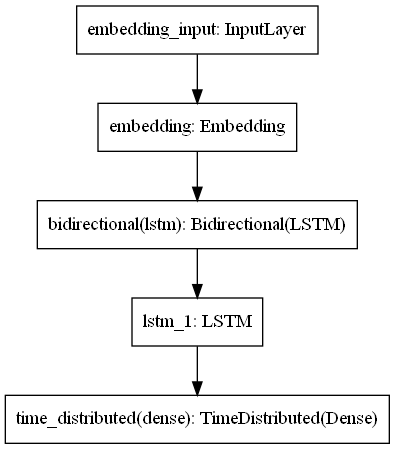

In [9]:
model = tf.keras.models.Sequential(
    [
        layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length), # Embedding vs Input layer
        layers.Bidirectional(layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'),
        layers.LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
        layers.TimeDistributed(layers.Dense(n_tags, activation="softmax")) #Use softmax for activation HOML page 383
    ]
)

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Hyper params to change - learning rate, number of layers and neurons, activations functions

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
model.summary()
plot_model(model)

In [10]:
history = model.fit(train_tokens, np.array(train_tags), epochs=20, callbacks=[tensorboard_cb], verbose=2)
%load_ext tensorboard
%tensorboard --logdir=./la_logs --port=6006

Epoch 1/20
75/75 - 45s - loss: 0.6060 - accuracy: 0.9401
Epoch 2/20
75/75 - 19s - loss: 0.2491 - accuracy: 0.9516
Epoch 3/20
75/75 - 21s - loss: 0.2257 - accuracy: 0.9516
Epoch 4/20
75/75 - 19s - loss: 0.1839 - accuracy: 0.9521
Epoch 5/20
75/75 - 21s - loss: 0.1355 - accuracy: 0.9589
Epoch 6/20
75/75 - 20s - loss: 0.1160 - accuracy: 0.9647
Epoch 7/20
75/75 - 21s - loss: 0.1059 - accuracy: 0.9668
Epoch 8/20
75/75 - 21s - loss: 0.0994 - accuracy: 0.9679
Epoch 9/20
75/75 - 20s - loss: 0.0944 - accuracy: 0.9692
Epoch 10/20
75/75 - 21s - loss: 0.0893 - accuracy: 0.9712
Epoch 11/20
75/75 - 21s - loss: 0.0838 - accuracy: 0.9733
Epoch 12/20
75/75 - 21s - loss: 0.0791 - accuracy: 0.9745
Epoch 13/20
75/75 - 21s - loss: 0.0746 - accuracy: 0.9760
Epoch 14/20
75/75 - 20s - loss: 0.0697 - accuracy: 0.9777
Epoch 15/20
75/75 - 21s - loss: 0.0663 - accuracy: 0.9791
Epoch 16/20
75/75 - 21s - loss: 0.0630 - accuracy: 0.9804
Epoch 17/20
75/75 - 21s - loss: 0.0599 - accuracy: 0.9816
Epoch 18/20
75/75 - 20s

Reusing TensorBoard on port 6006 (pid 8252), started 20:33:45 ago. (Use '!kill 8252' to kill it.)

In [11]:
y_pred = model.predict(test_tokens) #Calculates probability for each tag

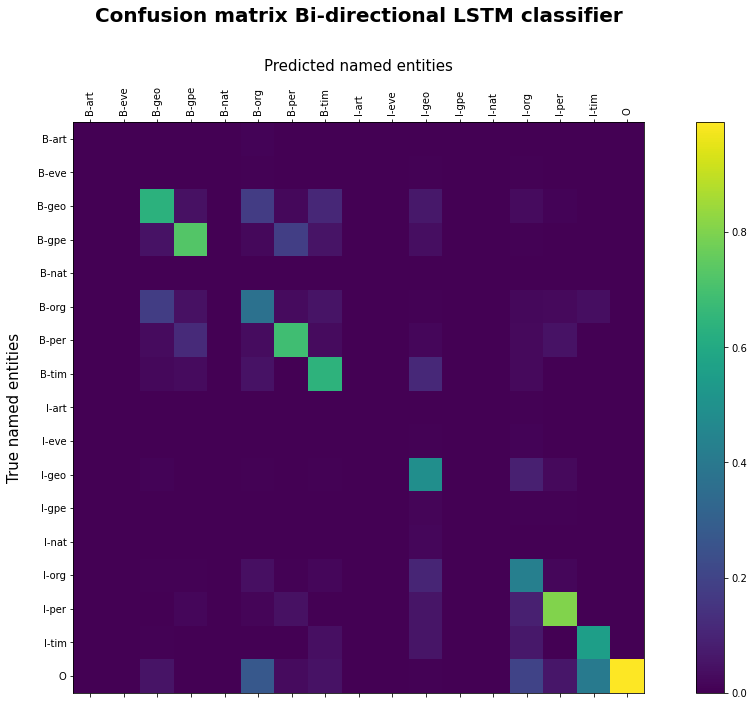

In [12]:
y_classes = y_pred.argmax(axis=-1)
cm_true = y_classes.flatten()
cm_pred = np.array(test_tags).argmax(axis=-1).flatten()

cm = confusion_matrix(cm_pred, cm_true, normalize='pred')
fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted named entities', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True named entities', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(len(tag_vocab)), tag_vocab, rotation=90)
plt.yticks(range(len(tag_vocab)), tag_vocab)
plt.show()